# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import os
import math
import json
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from tqdm.notebook import tqdm
from collections import defaultdict
import bisect
%matplotlib inline

In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True,)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# Add datetime to the dataframes:
transcript['datetime'] = pd.to_datetime(transcript['time']*3600000000000) # we don't know the exct time, so we use jan 1 1970 as strt
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


# Analyse data and cleanup

In this first step we will just look into the data to get more familiar, find if there's any null values etc etc.
The data itself is pretty much selfexplaining, some comments will be done in the start of each section that will explain the data below, but not much comments in the cells with data will be made to keep it cleaner.
We will also make an effort to clean up the data here, create dummies etc etc
### Portfolio

we don't use head here as this only contain 10 items anyway, i.e this is the full table.

a few things we may need to do with this data is to turn channels and offer_type into ine-hot-encoded columns to help processing these later on

The index will be kept with it's 0-9 instead of setting index to id, the reason is that it's more readable ( at it's likily that we will do plots and graphs based on each of these( as ther's only 10) and instead add link in other tables to have this index instead of the id.

from the class room:

> Offers sent during 30-day test period (10 offers x 6 fields)
* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) bogo, discount, informational
* id: (string/hash)

In [3]:
portfolio


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
for name, group in portfolio.groupby('offer_type'):
    print('###################################')
    print('#####   ',name)
    display(group.describe())

###################################
#####    bogo


,reward,difficulty,duration
count,4.000000,4.000000,4.000000
mean,7.500000,7.500000,6.000000
std,2.886751,2.886751,1.154701
min,5.000000,5.000000,5.000000
25%,5.000000,5.000000,5.000000
50%,7.500000,7.500000,6.000000
75%,10.000000,10.000000,7.000000
max,10.000000,10.000000,7.000000


###################################
#####    discount


,reward,difficulty,duration
count,4.000000,4.000000,4.000000
mean,3.000000,11.750000,8.500000
std,1.414214,5.678908,1.732051
min,2.000000,7.000000,7.000000
25%,2.000000,9.250000,7.000000
50%,2.500000,10.000000,8.500000
75%,3.500000,12.500000,10.000000
max,5.000000,20.000000,10.000000


###################################
#####    informational


,reward,difficulty,duration
count,2.0,2.0,2.000000
mean,0.0,0.0,3.500000
std,0.0,0.0,0.707107
min,0.0,0.0,3.000000
25%,0.0,0.0,3.250000
50%,0.0,0.0,3.500000
75%,0.0,0.0,3.750000
max,0.0,0.0,4.000000


In [7]:
pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1).drop(columns=['channels'])
#https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
display(portfolio)

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [8]:
for row in portfolio.itertuples():
    if row.difficulty == 0:
        print(0)
    else:
        print(row.offer_type,row.reward/row.difficulty)

bogo 1.0
bogo 1.0
0
bogo 1.0
discount 0.25
discount 0.42857142857142855
discount 0.2
0
bogo 1.0
discount 0.2


In [9]:
# this is my own logical order, nothing says it have to be this way, just what "feels better". bogo, discount, information
portfolio_my_order= [0,1,3,8,5,4,6,9,2,7]

In [10]:
idd = '9b98b8c7a33c4b65b9aebfe6a799e6d9'
int(portfolio.index[portfolio['id'] == idd].tolist()[0])


3

### Profile

>Rewards program users (17000 users x 5 fields)
* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [12]:
# Let's change the index to ID instead for faster and easier access
profile.set_index('id', inplace=True)

In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 68be06ca386d4c31939f3a4f0e3dd783 to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   became_member_on  17000 non-null  datetime64[ns]
 3   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 664.1+ KB


In [14]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [15]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
profile['age'][profile['age'] != 118].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

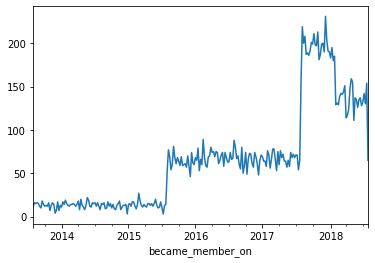

In [17]:
profile.groupby([pd.Grouper(key='became_member_on', freq='W')])['became_member_on'].count().plot()

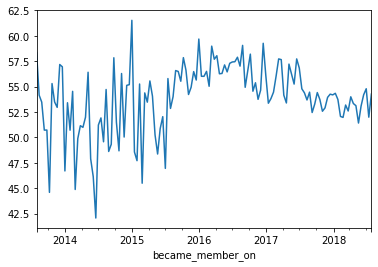

In [18]:
profile[profile['age'] != 118].groupby([pd.Grouper(key='became_member_on', freq='2W')])['age'].mean().plot()

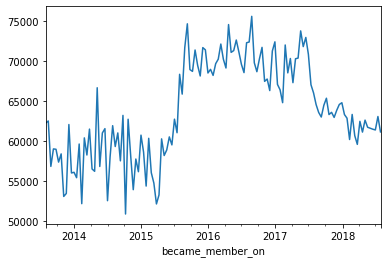

In [19]:
profile.groupby([pd.Grouper(key='became_member_on', freq='2W')])['income'].mean().plot()

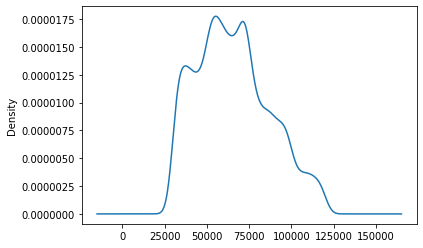

In [20]:
profile['income'].plot(kind='kde')

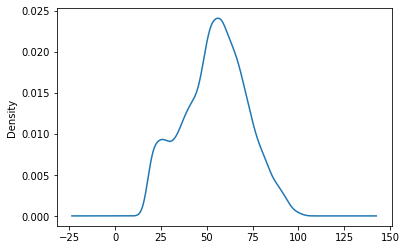

In [21]:
profile[profile['age'] != 118]['age'].plot(kind='kde')

### Transcript

In [22]:
transcript.head()

,person,event,value,time,datetime
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1970-01-01
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1970-01-01
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1970-01-01
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1970-01-01
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1970-01-01


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   person    306534 non-null  object        
 1   event     306534 non-null  object        
 2   value     306534 non-null  object        
 3   time      306534 non-null  int64         
 4   datetime  306534 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.7+ MB


In [24]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [251]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1970-01-01 00:00:00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,3.0,0.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,1970-01-01 06:00:00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,3.0,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,1970-01-06 12:00:00,None,NaN,19.89,0,0,0,1,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1970-01-06 12:00:00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,1,0,0,0,3.0,NaN
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,1970-01-07 00:00:00,None,NaN,17.78,0,0,0,1,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,1970-01-08 00:00:00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,1,0,0,7.0,1.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,1970-01-10 00:00:00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,0,1,0,7.0,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,1970-01-10 06:00:00,None,NaN,19.67,0,0,0,1,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,1970-01-11 00:00:00,None,NaN,29.72,0,0,0,1,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,1970-01-16 18:00:00,None,NaN,23.93,0,0,0,1,NaN,NaN


In [25]:
# extract data in value, first, what column do we need?
# we can see thaat we have 2 offer_id ( with and without the space, so we can put these into one
new_cols={
    'offer_id':[],
    'reward': [],
    'amount': []
}
for row in transcript.itertuples():
    t = row.event + " # " +  str(row.value.keys())
    offer_id = None
    reward = None
    amount = None
    if 'offer_id' in row.value.keys():
        offer_id = row.value['offer_id']
    if 'offer id' in row.value.keys():
        offer_id = row.value['offer id']
    if 'reward' in row.value.keys():
        reward = row.value['reward']
    if 'amount' in row.value.keys():  
        amount = row.value['amount']
    
    new_cols['offer_id'].append(offer_id)
    new_cols['reward'].append(reward)
    new_cols['amount'].append(amount)
        
    #allkeys[t]+=1

#print(json.dumps(allkeys, indent=4, sort_keys=True))
transcript = pd.concat([transcript, pd.DataFrame(new_cols).set_index(transcript.index)], axis=1).drop(columns=['value'])
dummies = pd.get_dummies(transcript['event'],columns=['event'])
transcript = pd.concat([transcript, dummies.set_index(transcript.index)], axis=1)


In [250]:
transcript.head(10)

,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1970-01-01,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,3.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1970-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,4.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,1970-01-01,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,9.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1970-01-01,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,6.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1970-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,1.0,0.0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,1970-01-01,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0,1,0,0,8.0,0.0
6,c4863c7985cf408faee930f111475da3,offer received,0,1970-01-01,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,0,1,0,0,5.0,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,1970-01-01,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0,2.0,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,1970-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,4.0,0.0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,1970-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,4.0,0.0


In [27]:
#Let's take another look at Nan values ( important for later) as we now in 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   person           306534 non-null  object        
 1   event            306534 non-null  object        
 2   time             306534 non-null  int64         
 3   datetime         306534 non-null  datetime64[ns]
 4   offer_id         167581 non-null  object        
 5   reward           33579 non-null   float64       
 6   amount           138953 non-null  float64       
 7   offer completed  306534 non-null  uint8         
 8   offer received   306534 non-null  uint8         
 9   offer viewed     306534 non-null  uint8         
 10  transaction      306534 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3), uint8(4)
memory usage: 17.5+ MB


In [28]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [29]:
transcript['offer_id'].nunique() * transcript['person'].nunique()

170000

In [30]:
# Make the offer id more human readable, good for plots etc later
def get_offer_index(x):
    return int(portfolio.index[portfolio['id'] == x].tolist()[0]) if x else x

transcript['offer_index'] = transcript['offer_id'].apply(lambda x: get_offer_index(x))

In [31]:
transcript.head(60000)


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1970-01-01,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,3.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1970-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,4.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,1970-01-01,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,9.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1970-01-01,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,6.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1970-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,ee756ebaea92411cb3c34a88293f0a5f,offer received,168,1970-01-08,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,6.0
59996,ff0c71628d3f4a4099062a36431452fe,offer received,168,1970-01-08,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,1,0,0,7.0
59997,7a9c803dd43c4bafaabed460b7325961,offer received,168,1970-01-08,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,1,0,0,7.0
59998,abd6e8f0ea7d4f0f877e1683213dabb9,offer received,168,1970-01-08,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0,2.0


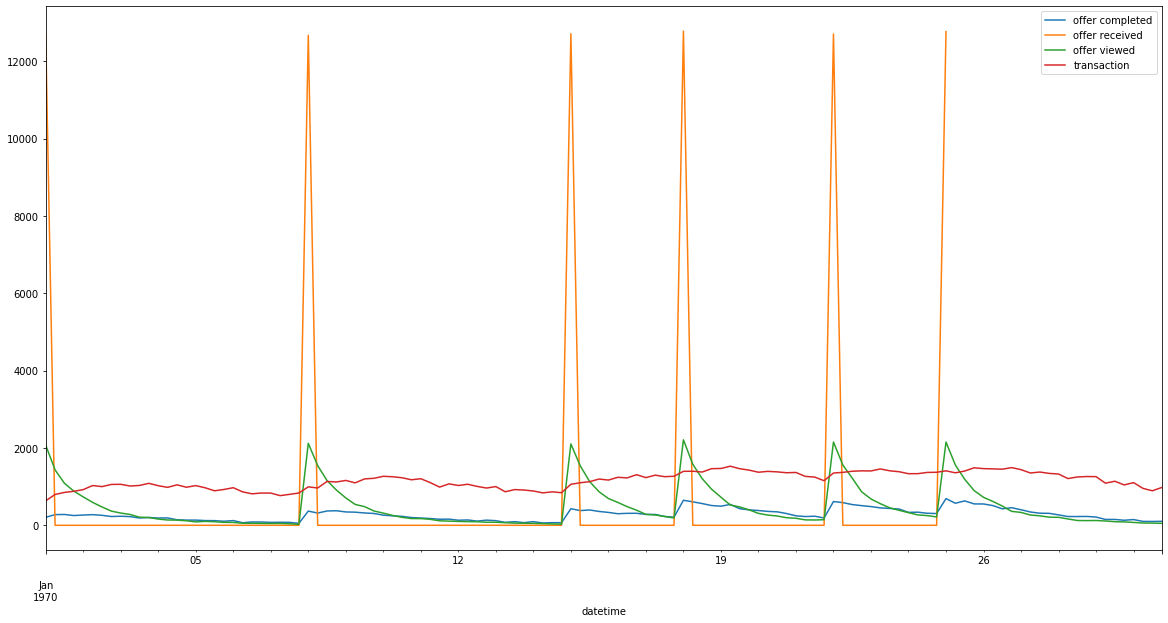

In [32]:
freq = '6H'
for i, x in transcript.groupby('event'):
    ax = x.groupby([pd.Grouper(key='datetime', freq=freq)])['event'].count().plot(figsize=(20,10), label=i)
ax.legend()

In [33]:
#In the plot above we can see that we have 6 bursts of sent offer, to process this later, we will but these into different groups
sendouts=np.array([5,12,16,20,23])*24 # this is not the date of the sendout, rather inbetween them..
for i, row in tqdm(transcript.iterrows(), total=len(transcript)):
    if row.event == 'offer received':
        offer_burst = bisect.bisect_left(sendouts,row.time)
        transcript.loc[i, "offer_burst"] = offer_burst


In [34]:

for i,(name, person) in enumerate(tqdm(transcript.dropna(subset=['offer_id']).groupby('person'))):
    for offerid, group in person.groupby(['offer_index']):
        display(group)
        display(portfolio.loc[offerid])
        print("########")
    break

,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
113605,0009655768c64bdeb2e877511632db8f,offer received,336,1970-01-15 00:00:00,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,1,0,0,2.0,2.0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,1970-01-16 12:00:00,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0,0,1,0,2.0,NaN


reward                                       0
difficulty                                   0
duration                                     4
offer_type                       informational
id            3f207df678b143eea3cee63160fa8bed
email                                        1
mobile                                       1
social                                       0
web                                          1
Name: 2, dtype: object

########


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
204340,0009655768c64bdeb2e877511632db8f,offer received,504,1970-01-22 00:00:00,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,6.0,4.0
228423,0009655768c64bdeb2e877511632db8f,offer completed,528,1970-01-23 00:00:00,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,1,0,0,0,6.0,NaN
233413,0009655768c64bdeb2e877511632db8f,offer viewed,540,1970-01-23 12:00:00,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,0,1,0,6.0,NaN


reward                                       2
difficulty                                  10
duration                                    10
offer_type                            discount
id            fafdcd668e3743c1bb461111dcafc2a4
email                                        1
mobile                                       1
social                                       1
web                                          1
Name: 6, dtype: object

########


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
55972,0009655768c64bdeb2e877511632db8f,offer received,168,1970-01-08,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,1,0,0,7.0,1.0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,1970-01-09,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,0,0,1,0,7.0,NaN


reward                                       0
difficulty                                   0
duration                                     3
offer_type                       informational
id            5a8bc65990b245e5a138643cd4eb9837
email                                        1
mobile                                       1
social                                       1
web                                          0
Name: 7, dtype: object

########


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
153401,0009655768c64bdeb2e877511632db8f,offer received,408,1970-01-18 00:00:00,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0,1,0,0,8.0,3.0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,1970-01-18 06:00:00,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,1,0,0,0,8.0,NaN
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,1970-01-20 00:00:00,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0,0,1,0,8.0,NaN


reward                                       5
difficulty                                   5
duration                                     5
offer_type                                bogo
id            f19421c1d4aa40978ebb69ca19b0e20d
email                                        1
mobile                                       1
social                                       1
web                                          1
Name: 8, dtype: object

########


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
247879,0009655768c64bdeb2e877511632db8f,offer received,576,1970-01-25,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,9.0,5.0
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,1970-01-25,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,1,0,0,0,9.0,NaN


reward                                       2
difficulty                                  10
duration                                     7
offer_type                            discount
id            2906b810c7d4411798c6938adc9daaa5
email                                        1
mobile                                       1
social                                       0
web                                          1
Name: 9, dtype: object

########


In [35]:
# count offer recieved per person (to see how the distributionwas done),
# any user with no offer?
# First look gave us that each user can actully get the same offer more than once??? and that combine with order made it unique to each user. 
count_offer = defaultdict(int)
pepl = set()
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    pepl.add(name)
    item = len(list(person['offer_index'].to_list()))
    count_offer[str(item)]+=1

In [36]:
print(json.dumps(count_offer, indent=4, sort_keys=True))

{
    "1": 73,
    "2": 610,
    "3": 2325,
    "4": 4988,
    "5": 5931,
    "6": 3067
}


In [37]:
# is it possible that there's a control group that had 0 offers?
# yes, but it's very limited. We could try to use this later,
# but may not be enough 
pepl = set()
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    pepl.add(name)
    
    ### NOTE this will fail if changing prifile index to id
display(profile[profile.index.isin(list(set(profile.index.to_list())-pepl))])
display(transcript[transcript['person'].isin(list(set(profile.index.to_list())-pepl))])

,gender,age,became_member_on,income
id,,,,
c6e579c6821c41d1a7a6a9cf936e91bb,F,72,2017-10-14,35000.0
da7a7c0dcfcb41a8acc7864a53cf60fb,None,118,2017-08-01,NaN
eb540099db834cf59001f83a4561aef3,F,66,2017-09-29,34000.0
3a4874d8f0ef42b9a1b72294902afea9,F,55,2016-08-16,88000.0
ae8111e7e8cd4b60a8d35c42c1110555,F,54,2017-01-06,72000.0
12ede229379747bd8d74ccdc20097ca3,M,91,2015-10-05,70000.0


,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
16379,eb540099db834cf59001f83a4561aef3,transaction,6,1970-01-01 06:00:00,None,NaN,4.74,0,0,0,1,NaN,NaN
22092,12ede229379747bd8d74ccdc20097ca3,transaction,18,1970-01-01 18:00:00,None,NaN,16.62,0,0,0,1,NaN,NaN
69477,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,174,1970-01-08 06:00:00,None,NaN,0.65,0,0,0,1,NaN,NaN
87239,c6e579c6821c41d1a7a6a9cf936e91bb,transaction,222,1970-01-10 06:00:00,None,NaN,1.91,0,0,0,1,NaN,NaN
106812,ae8111e7e8cd4b60a8d35c42c1110555,transaction,306,1970-01-13 18:00:00,None,NaN,17.51,0,0,0,1,NaN,NaN
108268,eb540099db834cf59001f83a4561aef3,transaction,318,1970-01-14 06:00:00,None,NaN,5.09,0,0,0,1,NaN,NaN
109340,3a4874d8f0ef42b9a1b72294902afea9,transaction,324,1970-01-14 12:00:00,None,NaN,22.75,0,0,0,1,NaN,NaN
109815,12ede229379747bd8d74ccdc20097ca3,transaction,324,1970-01-14 12:00:00,None,NaN,27.60,0,0,0,1,NaN,NaN
110707,ae8111e7e8cd4b60a8d35c42c1110555,transaction,330,1970-01-14 18:00:00,None,NaN,28.70,0,0,0,1,NaN,NaN
142347,3a4874d8f0ef42b9a1b72294902afea9,transaction,378,1970-01-16 18:00:00,None,NaN,27.20,0,0,0,1,NaN,NaN


In [38]:
bogo = []
infor = []
disc =[]
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    person_bogo=0
    person_infor=0
    person_disc=0
    for offerid, group in person.groupby(['offer_index']):
        offer_type = portfolio.loc[offerid]['offer_type']
        if offer_type == 'informational':
            person_infor+=1
        elif offer_type == 'bogo':
            person_bogo+=1
        elif offer_type == 'discount':
            person_disc+=1
        else:
            raise Exception('dffdfsfwrg')

    bogo.append(person_bogo)
    infor.append(person_infor)
    disc.append(person_disc)


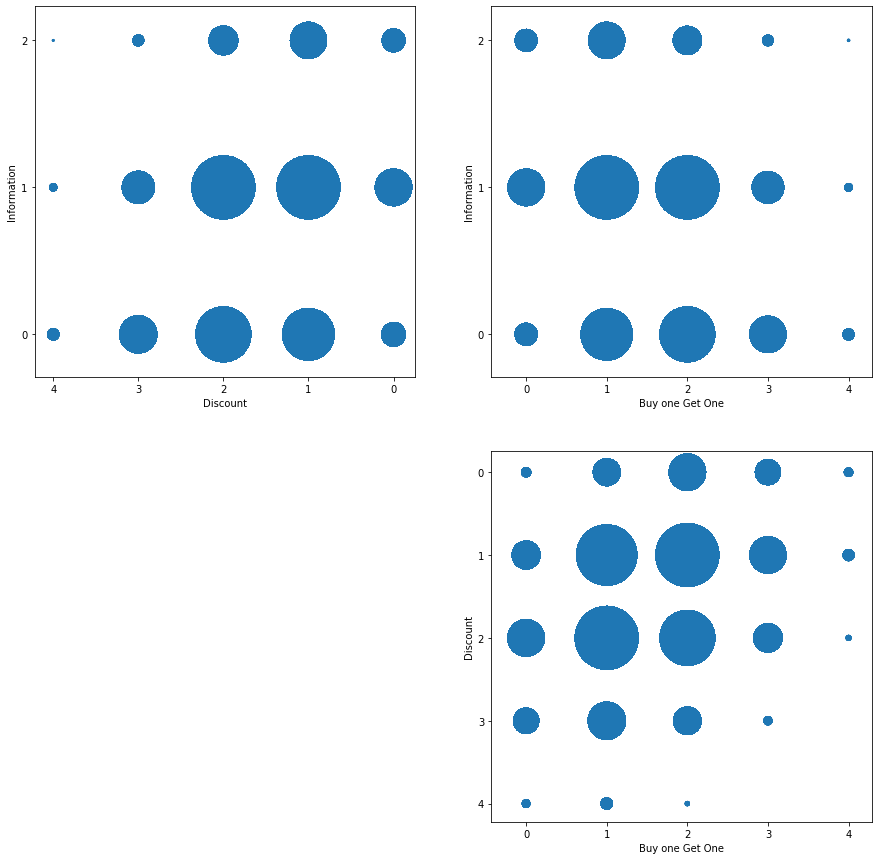

In [39]:
#This plot shows the distrubution of the number of offer recieved
from scipy.stats import gaussian_kde
x=bogo
y=infor
z=disc
xy = np.vstack([x,y,z])
n = gaussian_kde(xy)(xy)*5000

# Set up the axes with gridspec
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:1, 1:])
ax2 = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
ax3 = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

# scatter points on the main axes
main_ax.scatter(x, y, s=n, edgecolor='')
main_ax.set_xlabel('Buy one Get One')
main_ax.set_ylabel('Information')
main_ax.set_xticks(range(0,5))
main_ax.set_yticks(range(0,3))

ax2.scatter(z, y,  s=n, edgecolor='')
ax2.set_xlabel('Discount')
ax2.set_ylabel('Information')
ax2.invert_xaxis()
ax2.set_xticks(range(0,5))

ax3.scatter(x, z,  s=n, edgecolor='')
ax3.set_xlabel('Buy one Get One')
ax3.set_ylabel('Discount')
ax3.invert_yaxis()
ax3.set_yticks(range(0,5));

In [40]:
# next step. analyse the transaction in detail...
# we know that we have items where the user didn't look at the offer befor getting it, i.e didn't buy because of it.what we can do is maybe.
#from the time the user look at it. but those user in one group (those with atleast one item at all time) and the rest in another group?
# or we actually also want to see how much the transaction increased AFTER the offer. how can we do that?

In [41]:
have_offer=np.zeros((10,40*4))
have_offer_completed=np.zeros((10,40*4))
have_seen_offer=np.zeros((10,40*4))
have_seen_offer_completed=np.zeros((10,40*4))
for i,(name, person) in enumerate(tqdm(transcript.dropna(subset=['offer_id']).groupby('person'))):
    for offerid, group in person.groupby(['offer_index']):
        offerid = int(offerid)
        offer = portfolio.loc[offerid]
        viewed = 'offer viewed' in group['event'].values
        #int(portfolio.index[portfolio['id'] == x].tolist()[0])
        #received_time = int(group[group['event']=='offer received']['time'][0]/(24/4))
        received_time = int(group.loc[group['event']=='offer received','time'].to_list()[0]/(24/4))
        end_time = int(received_time + offer['duration']*4)
        if 'offer completed' in group['event'].values:
            complete_time = int(group.loc[group['event']=='offer completed','time'].to_list()[0]/(24/4))
            if viewed:
                view_time = int(group.loc[group['event']=='offer viewed','time'].to_list()[0]/(24/4))
                have_seen_offer_completed[offerid,view_time:complete_time]+=1
            else:
                have_offer_completed[offerid,received_time:complete_time]+=1
        else:
            if viewed:
                #if view_time > end_time:
                #    print(view_time, end_time)
                
                view_time = int(group.loc[group['event']=='offer viewed','time'].to_list()[0]/(24/4))
                have_seen_offer[offerid,view_time:view_time+4]+=1
            else:
                have_offer[offerid,received_time:end_time]+=1

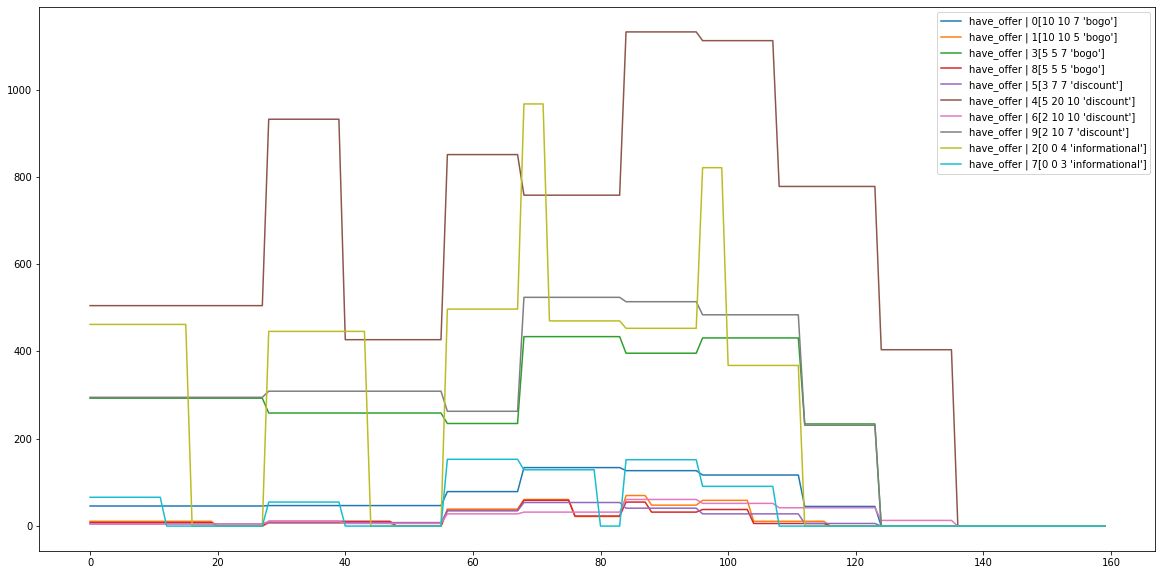

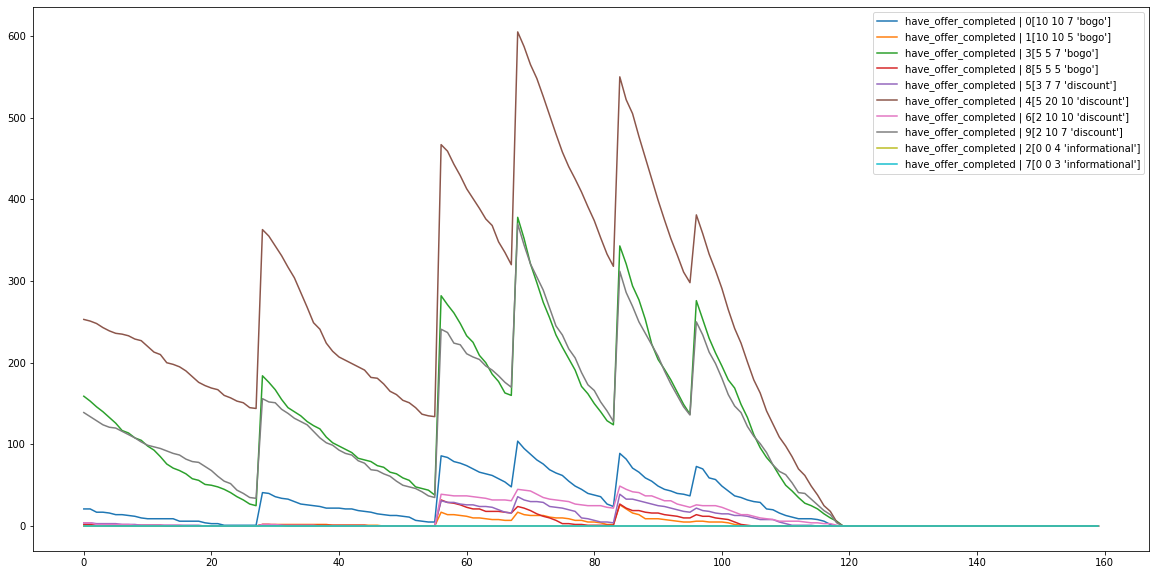

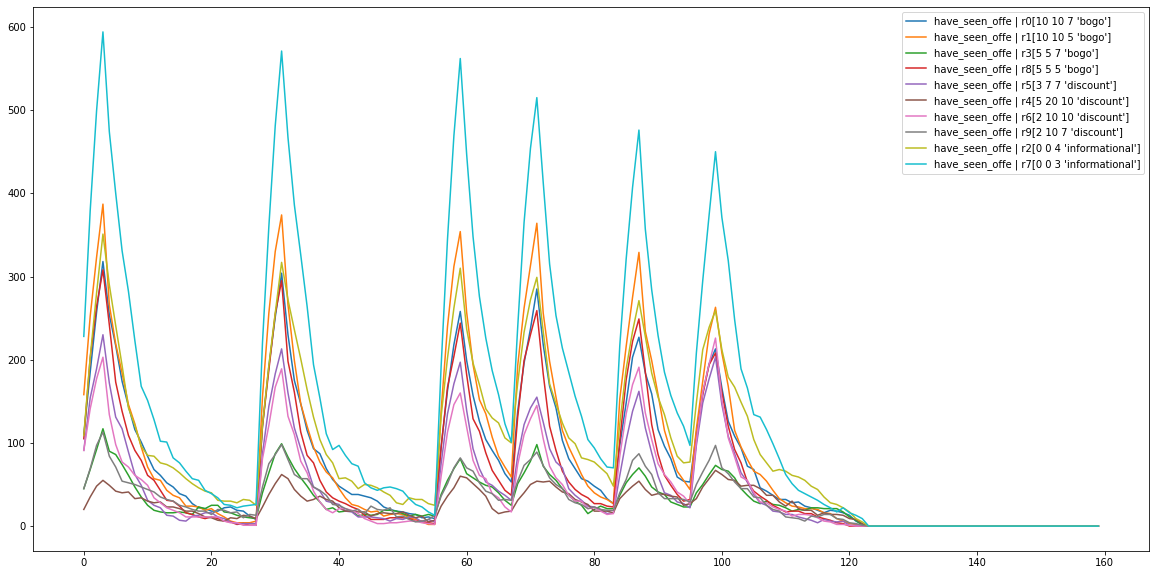

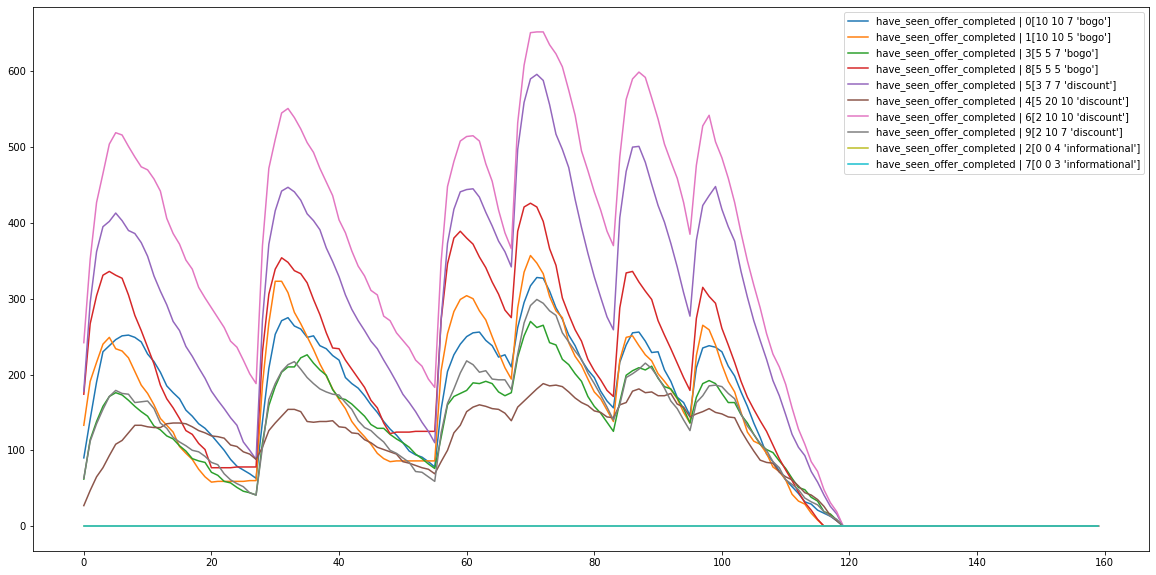

In [42]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for i in portfolio_my_order:
    label = "have_offer | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_offer_completed | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer_completed[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_seen_offe | r" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_seen_offer_completed | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer_completed[i,:], label=label);
plt.legend()
plt.show()

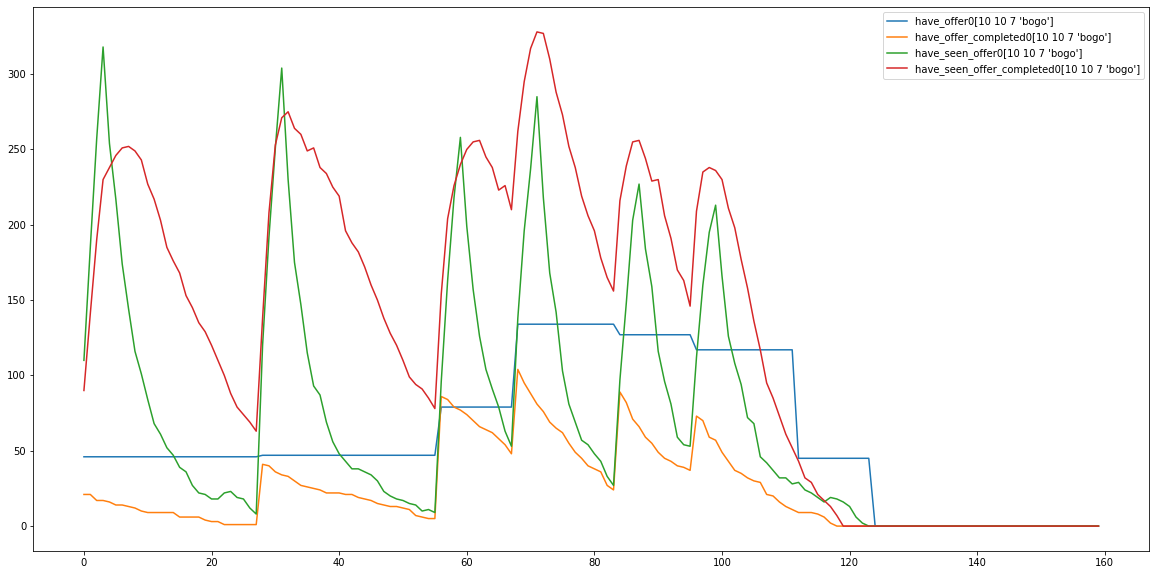

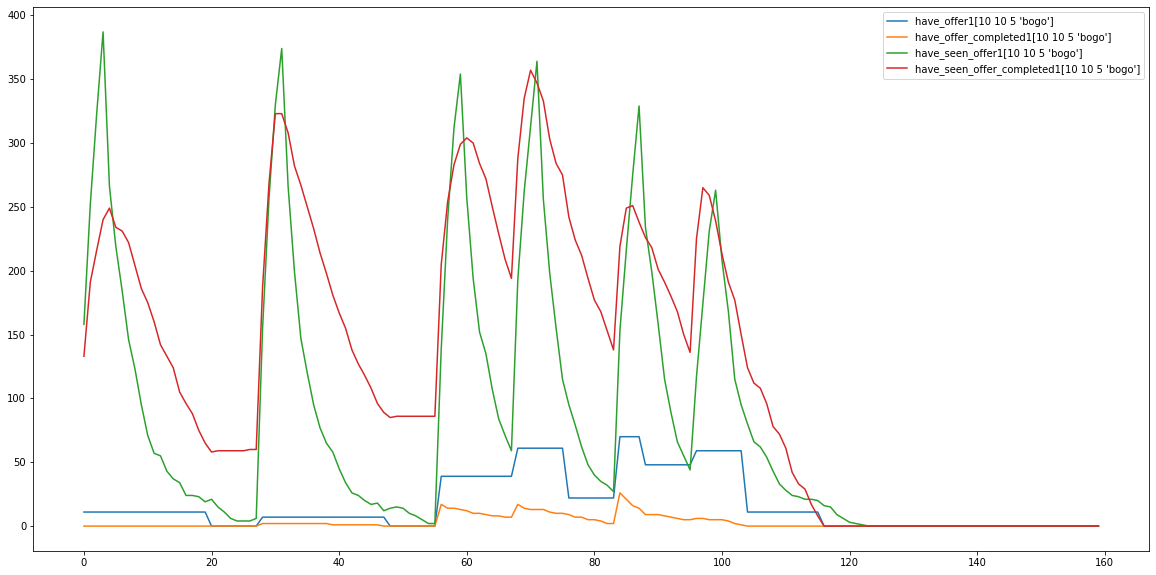

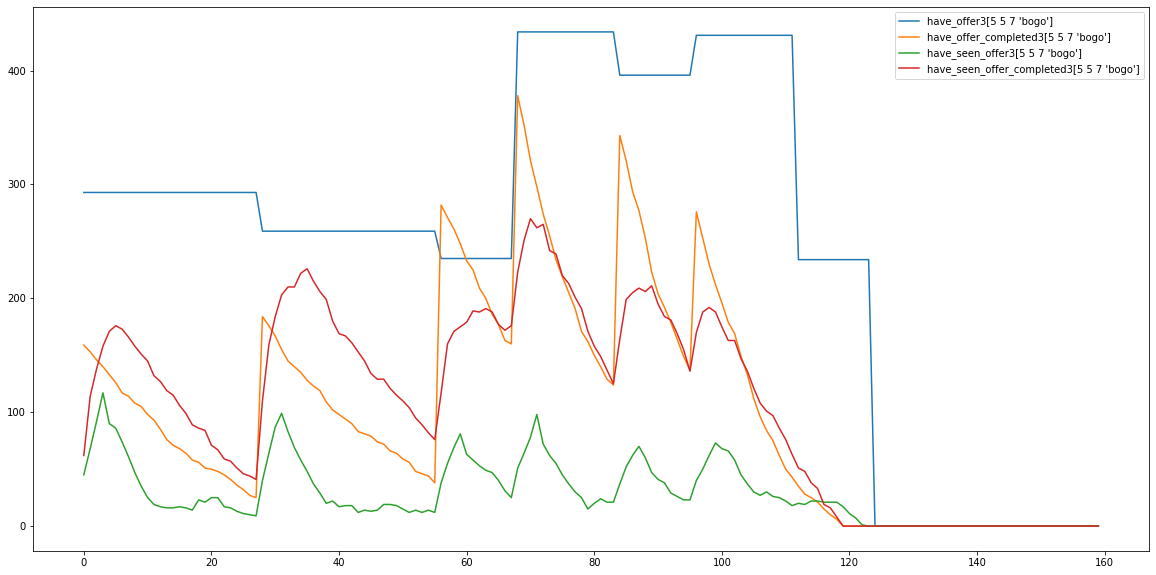

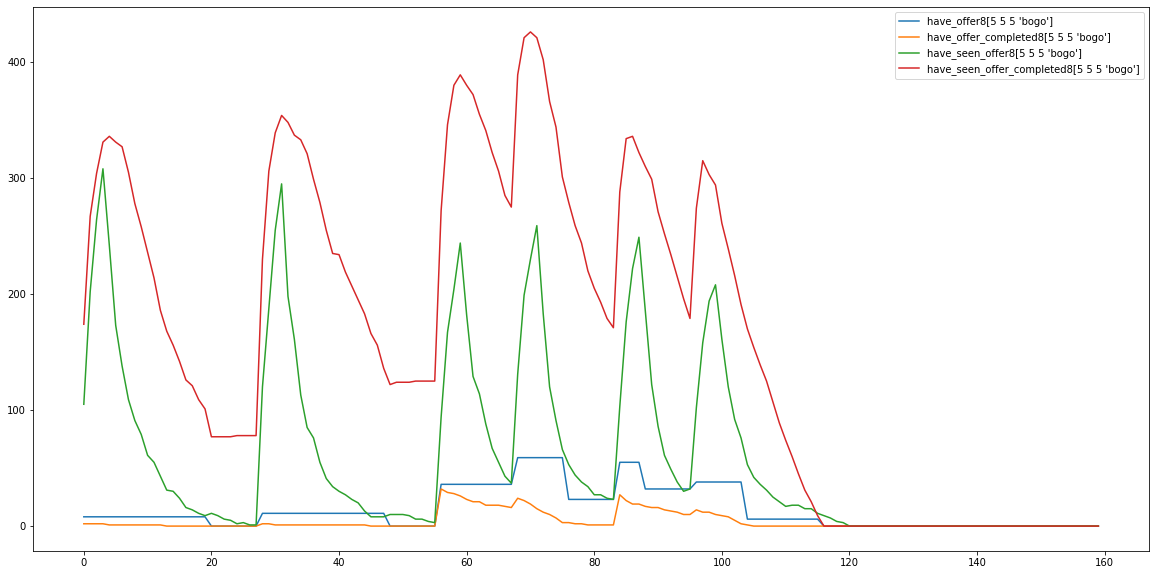

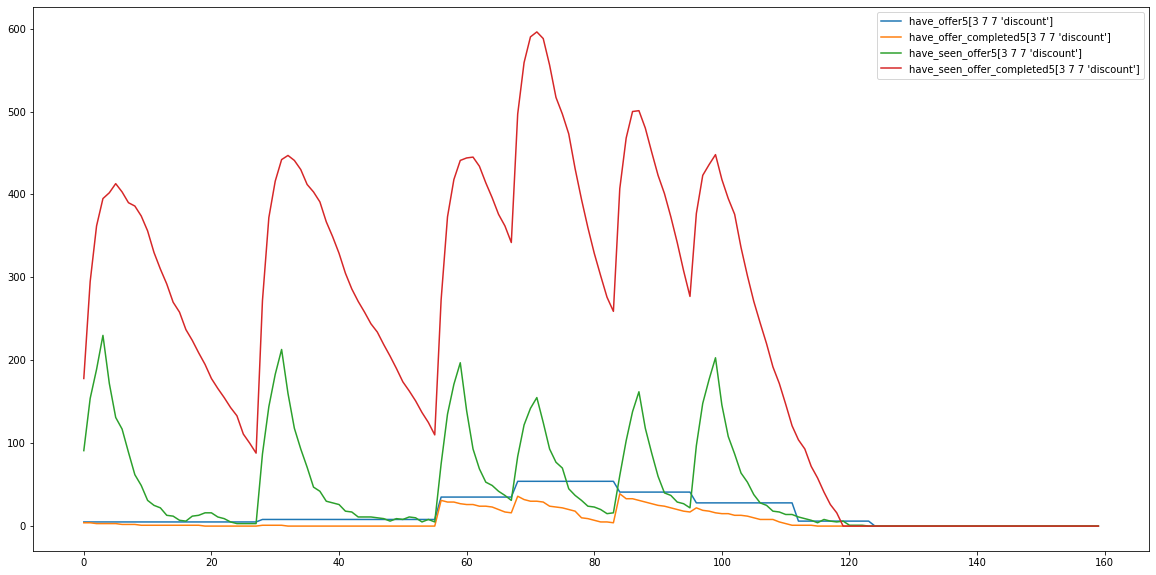

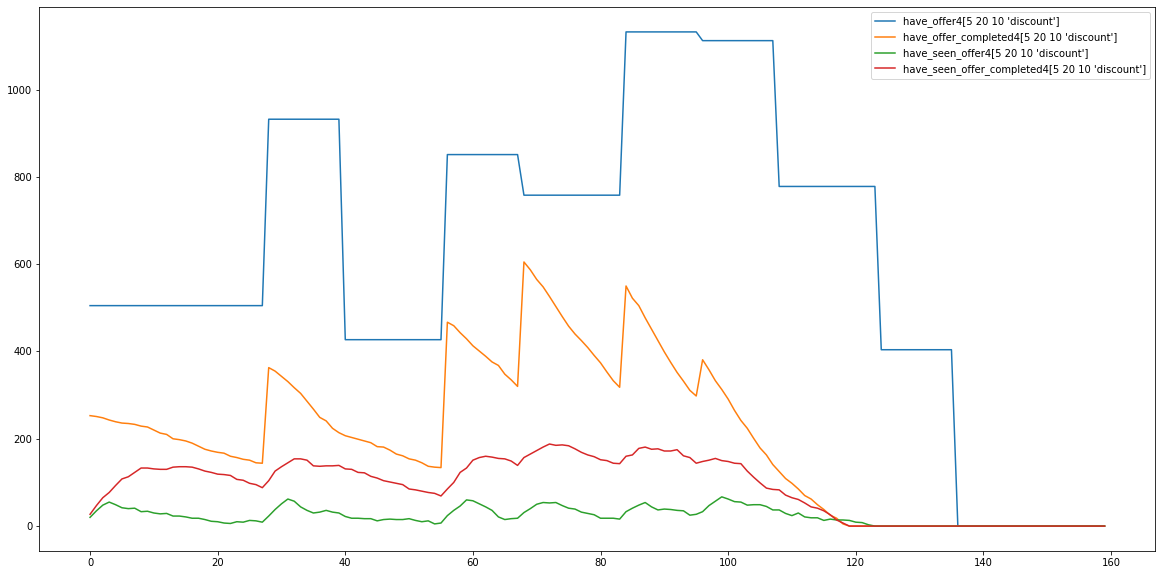

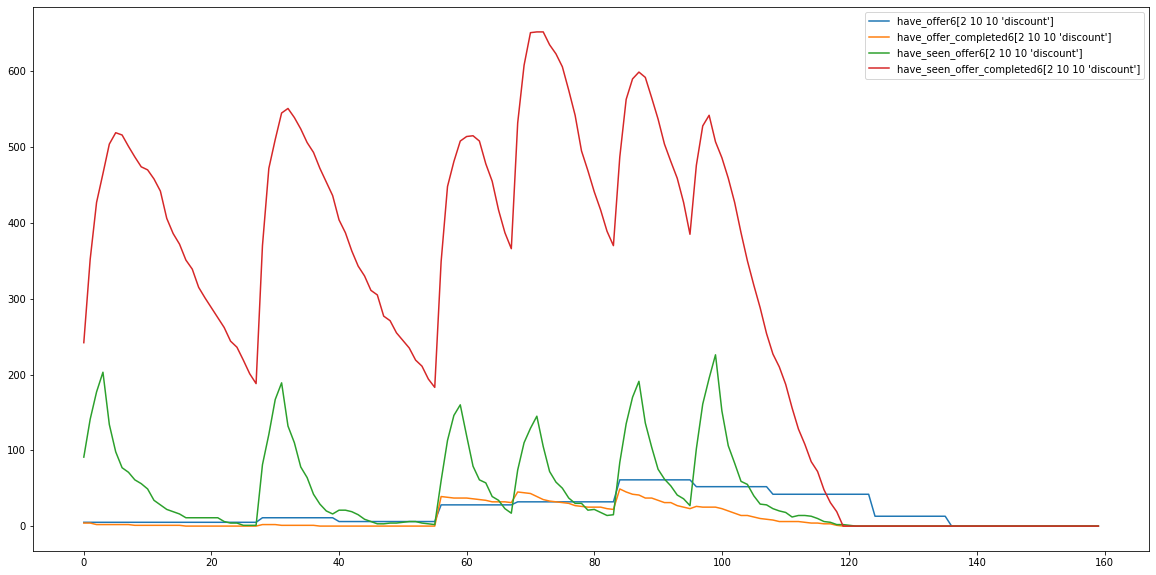

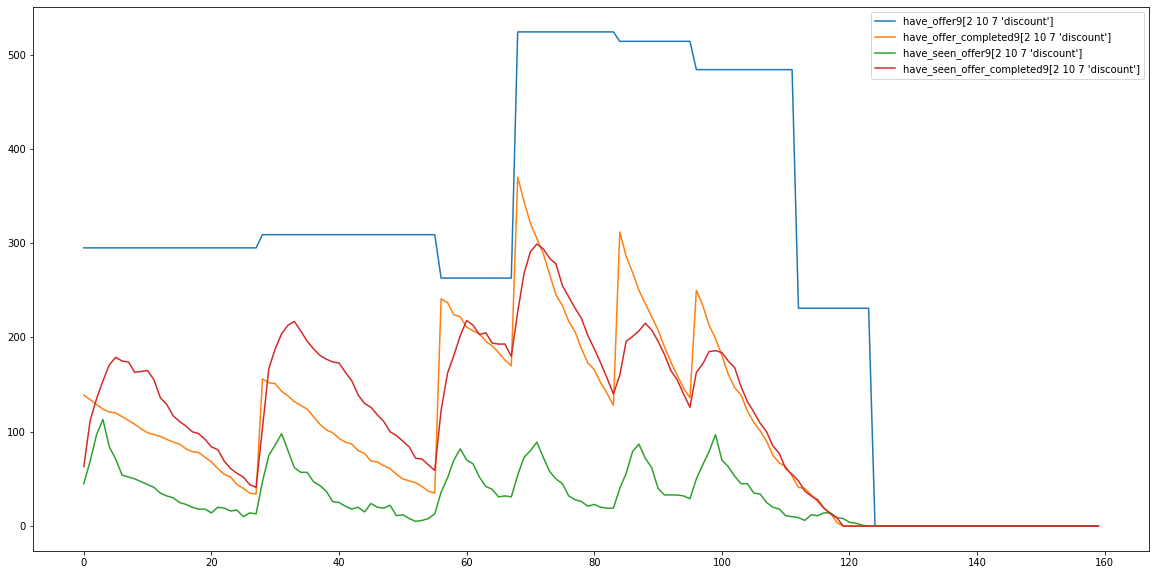

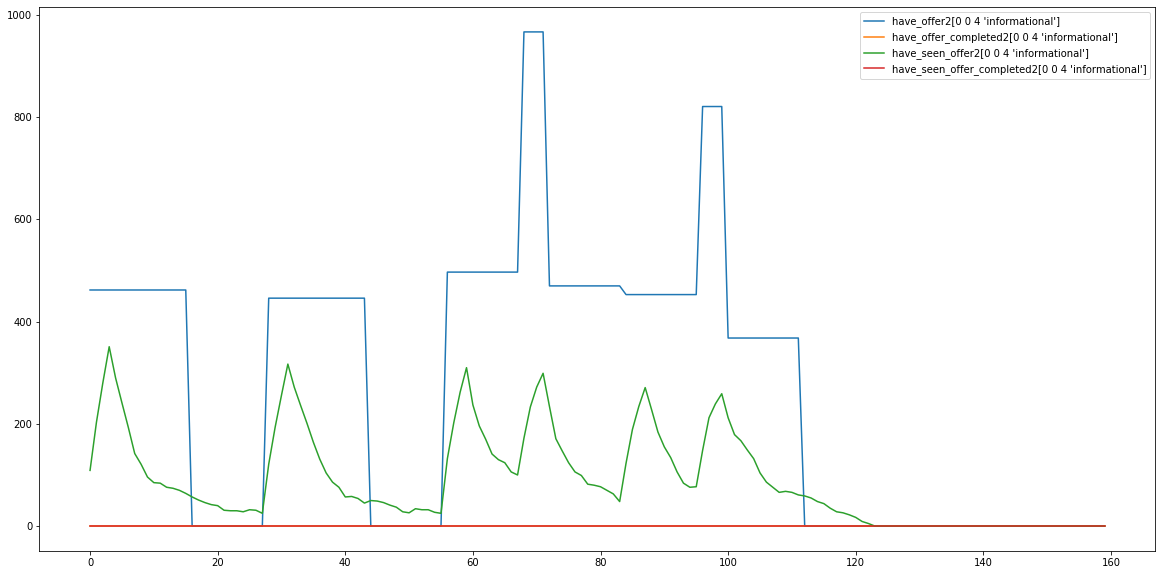

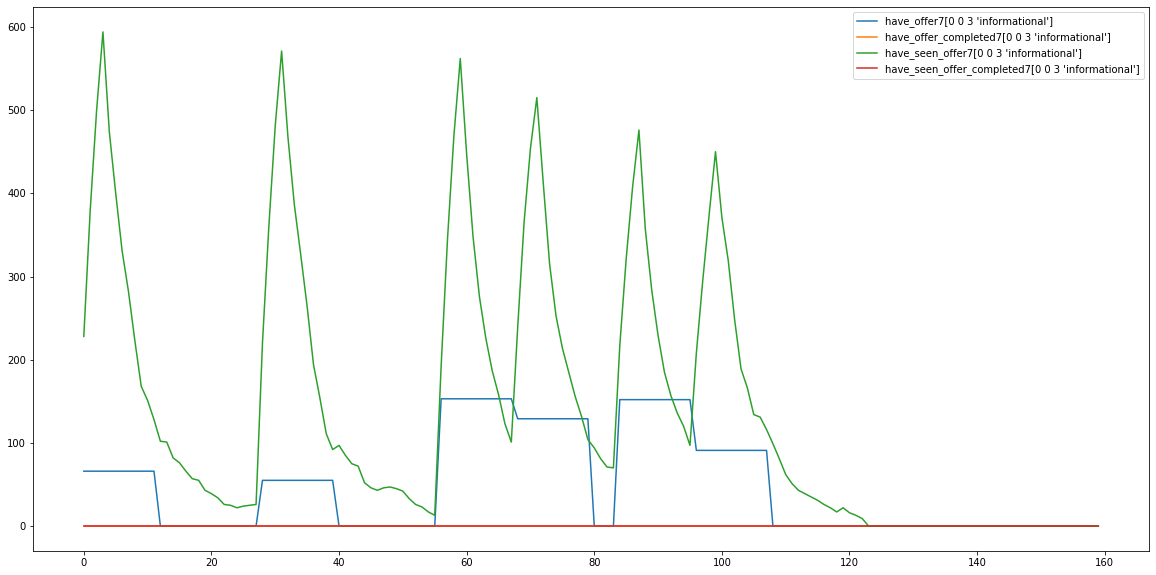

In [43]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for i in portfolio_my_order:
    label = "have_offer" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer[i,:], label=label);
    label = "have_offer_completed" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer_completed[i,:], label=label);
    label = "have_seen_offer" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer[i,:], label=label);
    label = "have_seen_offer_completed" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer_completed[i,:], label=label);
    plt.legend()
    plt.show()

{}


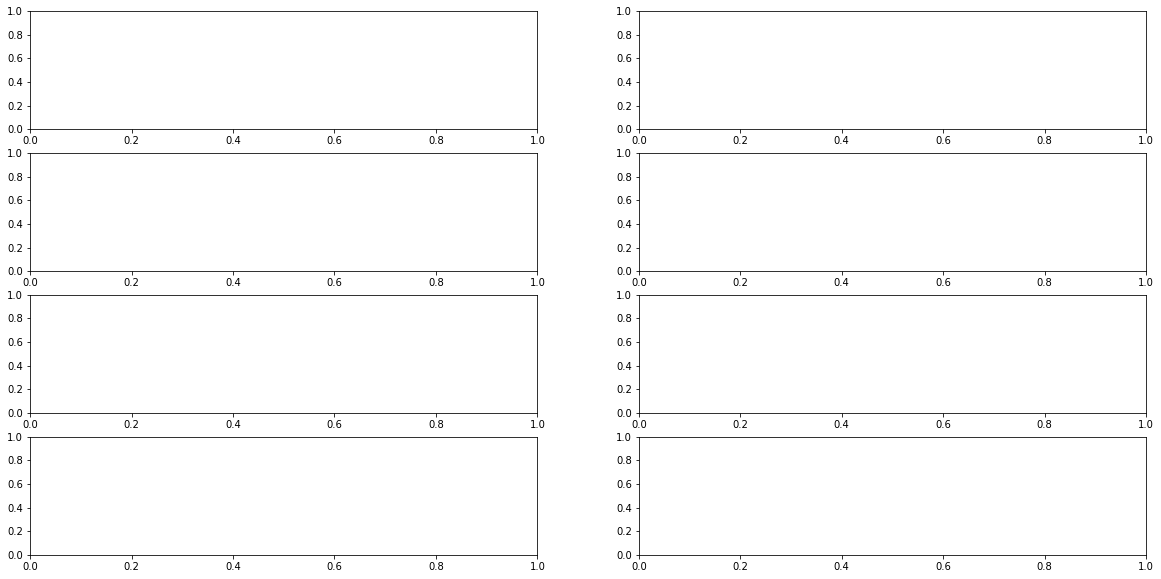

In [44]:
#plot 10 x 6
unique_order = defaultdict(int)
person_offer_df = pd.DataFrame()
#fig, axs = plt.subplots(1, 1)
fig, axs = plt.subplots(4,2)
for j, rows in tqdm(transcript[transcript['offer received']==1].groupby('offer_burst')):
    for i, portfolio_i in enumerate(tqdm(portfolio_my_order)):
        print(json.dumps(unique_order, indent=4, sort_keys=True))
        this_rows = rows[rows['offer_index']==portfolio_i]
        this_offer = portfolio.loc[portfolio_i] 
        offer_index = portfolio_i     
        start_date = this_rows.iloc[0]['time'] # all in this group is the same start time, in hours
        end_date = start_date + this_offer.duration * 24 # in days, converted to hours
        
        persons_complete_notview=[]
        persons_notcomplete_notview=[]
        persons_notcomplete_view=[]
        persons_complete_view=[]
        
        
        for person_id in tqdm(set(this_rows['person'])):
            

            person_offer = transcript[(transcript['person']==person_id) & 
                                      (transcript['offer_index']==offer_index) & 
                                      (transcript['time']>=start_date) &
                                      (transcript['time']<= end_date)]

            unique_order[str(list(person_offer['event']))] +=1
            continue
            def find_and_cut(a):
                for i, x in enumerate(a[1:]):
                    if x == 'offer completed':
                        #print("a",i)
                        #display(person_offer)
                        return i+2
                    if x == 'offer received':
                        return i+1
                return None
            person_offer = person_offer.iloc[:find_and_cut(person_offer['event'])]
            
            # now each person offer contains one unique offer
            # however, there's some concerns:
            # I noted that one person can get the same offer before viewing/completed athe first
            # how to treat these? the same offer but reminder?
            # or will the user now have two offers that is "the same" offer_id. if so
            # what if we have the following
            # user get offer A, user oen offer A, user get offer B, user use offer A, the offer B
            # here we can't distinguish offer A from B(same id) this may be a edge case and perhaps we can just ignore this
            # so for now offer A will be terminated when we have offer B
            # if these is to be solved, we need to get the whole date range. and sort them out,
            
            #TODO, here we can build our new df, person_offer_df
            oc=False
            ow=False

            for x in person_offer['event'][1:]:
                if x == 'offer completed':
                    oc=True
                elif x == 'offer viewed':
                    ow=True
            if oc and ow:
                persons_complete_view.append(person_id) 
            elif not oc and ow:
                persons_notcomplete_view.append(person_id) 
            elif not oc and not ow:
                persons_notcomplete_notview.append(person_id) 
            else:
                persons_complete_notview.append(person_id) 

            #take the transcript of this person & offerid betwen the date and this date+offer length
            #break
        if False: # Print TODO att try/catch here
            
            #TODO profile id will change to index profile[profile['id']
            this_profiles = profile[profile.index.isin(persons_notcomplete_notview)]
            this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[2,0])
            this_profiles['income'].plot(kind='kde', ax=axs[2,1])#[i,int(j)])

            this_profiles = profile[profile.index.isin(persons_notcomplete_view)]
            this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[1,0])
            this_profiles['income'].plot(kind='kde', ax=axs[1,1])#[i,int(j)])

            this_profiles = profile[profile.index.isin(persons_complete_view)]
            this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[0,0])
            this_profiles['income'].plot(kind='kde', ax=axs[0,1])#[i,int(j)])

            this_profiles = profile[profile.index.isin(persons_complete_notview)]
            this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[3,0])
            this_profiles['income'].plot(kind='kde', ax=axs[3,1])#[i,int(j)])
        #this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs)
       # display(this_rows)
        break
    break
        #this_profiles['income'].plot(kind='kde', ax=axs)#[i,int(j)])
            # here we will loop on the starts only!


In [45]:
np.array([5,12,16,20,23])*24

array([120, 288, 384, 480, 552])

A small "problem" is that we can get a new offer before the first one is ended. here's
a quick run over the them. this is within the time from the first "offer recieved" until validity date was out.
For the same person, and for the same offer id.
One scary case is these 
* ['offer received', 'offer viewed', 'offer received'] 
* ['offer received', 'offer received', 'offer viewed']
What if in both these cases, the second 'offer received' do have a offer complete, was that offer viewed or not?
is the answer in both cases be that the first was recieved but not opened, and not viewed, whereas the other 
was viewed and completed?

```{
    "['offer received', 'offer completed', 'offer received']": 13,
    "['offer received', 'offer completed', 'offer viewed', 'offer received', 'offer viewed']": 2,
    "['offer received', 'offer completed', 'offer viewed', 'offer received']": 11,
    "['offer received', 'offer completed', 'offer viewed']": 272,
    "['offer received', 'offer completed']": 216,
    "['offer received', 'offer received', 'offer completed', 'offer completed']": 1,
    "['offer received', 'offer received', 'offer viewed']": 2,
    "['offer received', 'offer received']": 34,
    "['offer received', 'offer viewed', 'offer completed', 'offer received', 'offer completed']": 5,
    "['offer received', 'offer viewed', 'offer completed', 'offer received', 'offer viewed']": 11,
    "['offer received', 'offer viewed', 'offer completed', 'offer received']": 53,
    "['offer received', 'offer viewed', 'offer completed']": 1687,
    "['offer received', 'offer viewed', 'offer received', 'offer completed', 'offer completed']": 2,
    "['offer received', 'offer viewed', 'offer received', 'offer viewed']": 7,
    "['offer received', 'offer viewed', 'offer received']": 66,
    "['offer received', 'offer viewed']": 2192,
    "['offer received']": 444
}```

In [46]:
#from a list of recieved, viewd and complete, how to link those together
#first belongs to first
# special cases
#start, start,view,endfirst,complete
# this could be:
# one start with view that was not complete and a start with no view but complete, however. this should be!!
# one start with no view, not complete, and a start with a view and a complete
'''
alla= [[('start',0), ('viewed',4), ('complete',6), ('start',8), ('viewed',10), ('complete',11)],
    [('start',0), ('viewed',4), ('complete',6)],
    [('start',0), ('viewed',4), ('start',6), ('complete',8), ('viewed',10), ('complete',11)],
    [('start',0), ('start',4), ('viewed',7), ('complete',11)],
    [('start',0), ('start',4), ('viewed',7), ('complete',9)]
      ]



for a in alla:
    print("###################################")
    print(a)
    final=[]
    current = []
    view_unknown = []
    validity = 10
    for x in a:

        #print("--------------------------")
        #print(f" x: {x}\n current: {json.dumps(current, indent=4, sort_keys=True)} \n view_unknown: {view_unknown} \n final: {json.dumps(final, indent=4, sort_keys=True)} ")
        #print("--------------------------")

        current_time = x[1]
        if current and current[0]['start']+validity < current_time:
            print('wtf')
            final.append(current.pop(0))
        if len(current) == 1 and len(view_unknown) > 0:
            current[0]['view'] = view_unknown.pop(0)
        if x[0]=='start':
            current.append({'start':current_time,'view':None, 'complete':None})

        elif x[0]=='viewed':
            if len(current)>1:
                view_unknown.append(current_time)
            elif current and view_unknown: # and :
                current[0]['view'] = view_unknown.pop(0)
                view_unknown.append(current_time)
            elif current:
                current[0]['view'] = current_time
            else: 
                raise Exception("error A")

        elif x[0]=='complete':
            if current[0]['view'] is None and view_unknown:
                current[0]['view'] = view_unknown.pop(0)
            current[0]['complete'] = current_time
            final.append(current.pop(0))
        else:
            raise Exception("error B")
    
    print("--------------------------")
    print(f" End result \n current: {json.dumps(current, indent=4, sort_keys=True)} \n view_unknown: {view_unknown} \n final: {json.dumps(final, indent=4, sort_keys=True)} ")
    print("--------------------------")        
'''
def create_person_offer(person_offer_df, this_offer, person_id, offer_index, transcript_grouped):
    '''
    a function to genereta a new df with person and offer per row,
    In manycases this will only add one row, however ther's also alot of rows with 
    Multiple from the same combination, which may even overlap
    
    in:
    person_offer_df, append to this
    this offer, current offer
    person_id, offer_index
    transcript_grouped, only one offer type, one person
    
    
    '''
    '''
    to_be_appended = {
        'person':[],
        'offer':[],
        'start':[], # in time
        'viewed_time':[], # in time
        'completed_time':[], # in time
        'viewed':[], # binary yes or no
        'completed':[], # binary yes or no
        'viewed_after':[]
        # here we can add more(basically dublicates from other df)
    }'''

    to_be_appended = defaultdict(list)
    def append_final(item):
        # this metod takes complete item and appends it
        to_be_appended['person'].append(person_id)
        to_be_appended['offer'].append(offer_index)
        to_be_appended['start'].append(item['start'])
        to_be_appended['viewed_time'].append(item['view'])
        to_be_appended['completed_time'].append(item['complete'])
        to_be_appended['viewed'].append(item['view'] is not None)
        to_be_appended['completed'].append(item['complete'] is not None)
        to_be_appended['viewed_after'].append(False)

        
    #todo, doublecheck all times
    current = []
    view_unknown = []
    validity = this_offer['duration']*24 #in hours
    debuglist=[]
    for row in transcript_grouped.itertuples():
        '''
        print("--------------------------")
        display(row)
        print(f" current: {json.dumps(current, indent=4, sort_keys=True)} \n view_unknown: {view_unknown} \n ")
        display(pd.DataFrame(to_be_appended))
        print("--------------------------")
        '''
        current_time = row.time # in hours
        current_event = row.event
        debuglist.append((row.event,row.time))
        if current and current[0]['start']+validity < current_time:
            append_final(current.pop(0))
        if len(current) == 1 and view_unknown:
            current[0]['view'] = view_unknown.pop(0)
        if current_event == 'offer received':
            current.append({'start':current_time,'view':None, 'complete':None})

        elif current_event=='offer viewed':
            if len(current)>1:
                view_unknown.append(current_time)
            elif current and view_unknown: # and :
                current[0]['view'] = view_unknown.pop(0)
                view_unknown.append(current_time)
            elif current:
                current[0]['view'] = current_time
            else:
                to_be_appended['viewed_after'][-1]=True
                #print('user viewed item AFTER it was user')


        elif current_event=='offer completed':
            if current[0]['view'] is None and view_unknown:
                current[0]['view'] = view_unknown.pop(0)
            current[0]['complete'] = current_time
            append_final(current.pop(0))
        else:
            print()
            print("---------ERROR B-----------------")
            display(row)
            print(f" current: {json.dumps(current, indent=4, sort_keys=True)} \n view_unknown: {view_unknown} \n ")
            display(pd.DataFrame(to_be_appended))
            print("--------------------------")
            print(debuglist)
            raise Exception("error B")
    for item in current: # if there's anything left at the end
        if item['view'] is None and view_unknown:
            item['view'] = view_unknown.pop(0)
        append_final(item)
    
    # Add common cells for all these
    this_person = profile.loc[person_id]
    nrows = len(to_be_appended['viewed'])
    
    for x in ['gender','age','became_member_on','income']:
        to_be_appended[x] = [this_person[x]]*nrows
    for x in ['reward','difficulty','duration','offer_type',
              'id','email', 'mobile','social','web']:
        to_be_appended[x] = [this_offer[x]]*nrows

    new_df = pd.DataFrame(to_be_appended)
    '''
    to_add_profile = pd.concat([profile.loc[[person_id],
                                                ['gender','age',
                                                 'became_member_on','income']
                                                ]]*len(new_df.index)).reset_index(drop=True)

    # reward,difficulty,duration,offer_type,id,email,mobile,social,web
    to_add_portfolio = pd.concat([portfolio.loc[[offer_index],
                                                 ['reward','difficulty','duration',
                                                  'offer_type','id','email',
                                                  'mobile','social','web']
                                                ]]*len(new_df.index)).reset_index(drop=True)
    
    new_df = pd.concat([new_df,to_add_profile,to_add_portfolio], axis=1)
    '''
    # This does not work because it obviosly different shapes
    if person_offer_df is not None:
        return person_offer_df.append(new_df, ignore_index = True) 
    else:
        return pd.DataFrame(new_df)
    
# This takes some time to complete, so read a saved file instead
# 
person_offer_file = 'data/person_offer.csv'
if os.path.isfile(person_offer_file):
    person_offer_df = pd.read_csv(person_offer_file)
else:
    raise Exception('TODO, This is just to see that ')
    person_offer_df = None
    # This will not include transaction, so we need anoyher new table for those.
    for (person_id, offer_index), transcript_grouped in tqdm(transcript.dropna(subset=['offer_index']).groupby(['person','offer_index'])):
        this_offer = portfolio.loc[offer_index]
        person_offer_df = create_person_offer(person_offer_df, this_offer, person_id, offer_index, transcript_grouped)

    person_offer_df.to_csv(person_offer_file, index_label=False)
display(person_offer_df)


,person,offer,start,viewed_time,completed_time,viewed,completed,viewed_after,gender,age,...,income,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2.0,336,372.0,NaN,True,False,False,M,33,...,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,6.0,504,NaN,528.0,False,True,True,M,33,...,72000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,7.0,168,192.0,NaN,True,False,False,M,33,...,72000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,8.0,408,NaN,414.0,False,True,True,M,33,...,72000.0,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,9.0,576,NaN,576.0,False,True,False,M,33,...,72000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,4.0,168,174.0,198.0,True,True,False,F,45,...,62000.0,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
76273,ffff82501cea40309d5fdd7edcca4a07,6.0,0,6.0,60.0,True,True,False,F,45,...,62000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
76274,ffff82501cea40309d5fdd7edcca4a07,9.0,336,354.0,384.0,True,True,False,F,45,...,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
76275,ffff82501cea40309d5fdd7edcca4a07,9.0,408,414.0,414.0,True,True,False,F,45,...,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [116]:

person_transaction = transcript[transcript['event']=='transaction'].groupby(['person',pd.Grouper(key='datetime', freq='D')])[['amount']].sum()
person_transaction = person_transaction.unstack(level=-1).fillna(0) #.add_suffix('_Count').reset_index()
person_transaction = person_transaction['amount'] # What did I do wrong, how to not get this extra amount?
person_transaction.head()

datetime,1970-01-01,1970-01-02,1970-01-03,1970-01-04,1970-01-05,1970-01-06,1970-01-07,1970-01-08,1970-01-09,1970-01-10,...,1970-01-21,1970-01-22,1970-01-23,1970-01-24,1970-01-25,1970-01-26,1970-01-27,1970-01-28,1970-01-29,1970-01-30
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,22.16,...,0.0,0.00,14.11,13.56,10.27,0.00,0.00,12.36,28.16,18.41
00116118485d4dfda04fdbaba9a87b5c,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.00,0.00,0.00,0.0,13.49,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,22.05,0.00,23.03,8.96,0.00,0.00
0020c2b971eb4e9188eac86d93036a77,0.0,0.00,49.63,24.39,0.0,0.00,24.31,0.0,0.0,0.00,...,0.0,17.24,33.86,0.00,0.00,0.00,0.00,0.00,0.00,47.43
0020ccbbb6d84e358d3414a3ff76cffd,0.0,16.27,0.00,0.00,0.0,0.00,0.00,0.0,0.0,11.65,...,0.0,0.00,0.00,0.00,0.00,10.32,0.00,0.00,7.47,0.00


In [277]:
people_error = []
def get_before_after_mean(x):

    person_id = x.person
    
    def split_before_after(time, columns):
        if np.isnan(time):
            before = []
            current = []
            after = []
        else:
            currentday = int(time)//24
            before = columns[:currentday]
            current = columns[currentday]
            after = columns[currentday+1:]
        return (before, current, after)
    
    def mean0(items):
        if len(items) > 0:
            return items.mean()
        else:
            return 0
    
    try:
        person_row = person_transaction.loc[person_id]
        col = person_transaction.columns
        before_start, current_start, after_start = split_before_after(x.start, col)
        before_view, current_view, after_view = split_before_after(x.viewed_time, col)
        before_complete, current_complete, after_complete = split_before_after(x.completed_time, col)

        x['before_start'] = mean0(person_row[before_start])
        x['same_day_start'] = person_row[current_start].sum()
        x['after_start'] = mean0(person_row[after_start])
    
        x['before_view'] = mean0(person_row[before_view])
        x['same_day_view'] = person_row[current_view].sum()
        x['after_view'] = mean0(person_row[after_view])
        
        x['before_complete'] = mean0(person_row[before_complete])
        x['same_day_complete'] = person_row[current_complete].sum()
        x['after_complete'] = mean0(person_row[after_complete])
    except KeyError as e:
        people_error.append(e)
        print("E", end='')
        #raise
        x['before_start'] = 0
        x['same_day_start'] = 0
        x['after_start'] = 0
        x['before_view'] = 0
        x['same_day_view'] = 0
        x['after_view'] = 0
        x['before_complete'] = 0
        x['same_day_complete']= 0
        x['after_complete'] = 0
        
    return x

pd.set_option('display.max_columns', None)
tqdm.pandas()
person_offer_tr_df= person_offer_df.progress_apply(get_before_after_mean, axis=1)    
display(person_offer_tr_df)

#get_before_after_mean('0011e0d4e6b944f998e987f904e8c1e5', 6*24)


EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

,person,offer,start,viewed_time,completed_time,viewed,completed,viewed_after,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,id,email,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete
0,0009655768c64bdeb2e877511632db8f,2.0,336,372.0,NaN,True,False,False,M,33,2017-04-21,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,1.582857,0.00,7.029333,1.477333,0.00,7.531429,0.000000,0.00,0.000000
1,0009655768c64bdeb2e877511632db8f,6.0,504,NaN,528.0,False,True,True,M,33,2017-04-21,72000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1.463333,0.00,12.108750,0.000000,0.00,0.000000,1.396818,14.11,11.822857
2,0009655768c64bdeb2e877511632db8f,7.0,168,192.0,NaN,True,False,False,M,33,2017-04-21,72000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0.000000,0.00,5.800000,0.000000,0.00,6.076190,0.000000,0.00,0.000000
3,0009655768c64bdeb2e877511632db8f,8.0,408,NaN,414.0,False,True,True,M,33,2017-04-21,72000.0,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1.303529,8.57,8.072500,0.000000,0.00,0.000000,1.303529,8.57,8.072500
4,0009655768c64bdeb2e877511632db8f,9.0,576,NaN,576.0,False,True,False,M,33,2017-04-21,72000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,2.433333,10.27,11.786000,0.000000,0.00,0.000000,2.433333,10.27,11.786000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,4.0,168,174.0,198.0,True,True,False,F,45,2016-11-25,62000.0,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,4.622857,0.00,8.805000,4.622857,0.00,8.805000,4.045000,38.11,7.409524
76273,ffff82501cea40309d5fdd7edcca4a07,6.0,0,6.0,60.0,True,True,False,F,45,2016-11-25,62000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0.000000,0.00,7.795517,0.000000,0.00,7.795517,0.000000,16.06,7.778148
76274,ffff82501cea40309d5fdd7edcca4a07,9.0,336,354.0,384.0,True,True,False,F,45,2016-11-25,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,9.195000,0.00,6.489333,9.195000,0.00,6.489333,8.045625,15.57,6.290000
76275,ffff82501cea40309d5fdd7edcca4a07,9.0,408,414.0,414.0,True,True,False,F,45,2016-11-25,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,8.488235,17.55,5.351667,8.488235,17.55,5.351667,8.488235,17.55,5.351667


In [ ]:
person_offer_tr_df_file = 'data/person_offer_tr_df.csv'
person_offer_tr_df.to_csv(person_offer_tr_df_file, index_label=False)
person_offer_tr_df.describe()

## Analyse the new person offer DataFrame


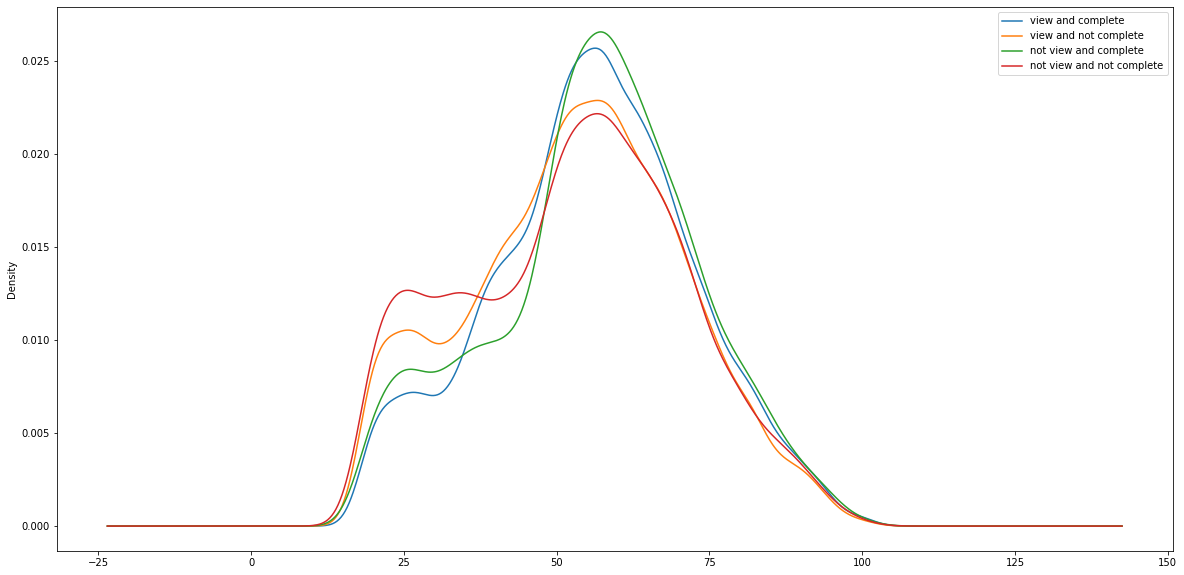

In [47]:
viewed = person_offer_df['viewed']
completed = person_offer_df['completed']
ageok = person_offer_df['age'] != 118

ax = person_offer_df[viewed & completed & ageok]['age'].plot.density(label='view and complete', figsize=(20,10))
person_offer_df[viewed & ~completed & ageok]['age'].plot.density(ax=ax, label='view and not complete')
person_offer_df[~viewed & completed & ageok]['age'].plot.density(ax=ax, label='not view and complete')
person_offer_df[~viewed & ~completed & ageok]['age'].plot.density(ax=ax, label='not view and not complete')
ax.legend()

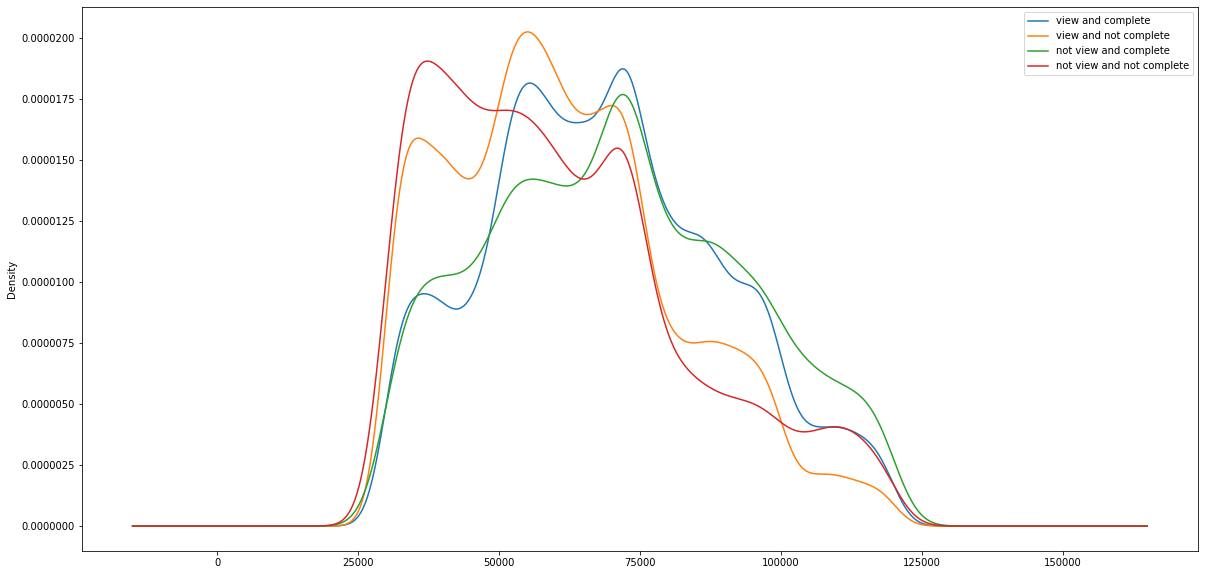

In [48]:
ax = person_offer_df[viewed & completed]['income'].plot.density(label='view and complete', figsize=(20,10))
person_offer_df[viewed & ~completed]['income'].plot.density(ax=ax, label='view and not complete')
person_offer_df[~viewed & completed]['income'].plot.density(ax=ax, label='not view and complete')
person_offer_df[~viewed & ~completed]['income'].plot.density(ax=ax, label='not view and not complete')
ax.legend()

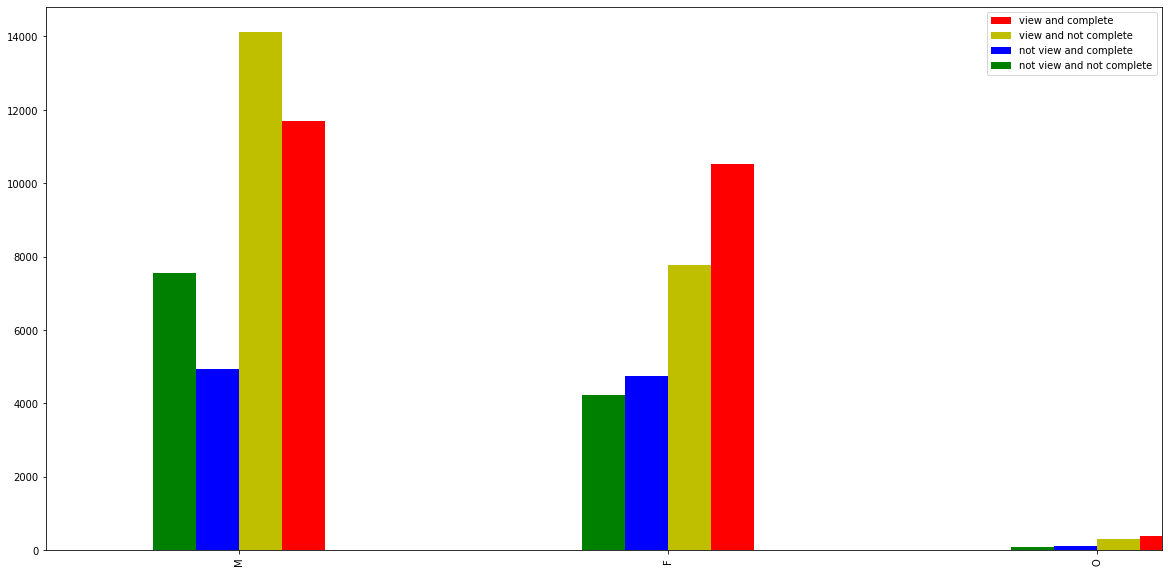

In [49]:
# TODO, how to get these plot nicer?? it's impossible to plot it even...
ax = person_offer_df[viewed & completed]['gender'].value_counts().plot.bar(label='view and complete',position=-1, width = 0.1, color='r', figsize=(20,10))
person_offer_df[viewed & ~completed]['gender'].value_counts().plot.bar(ax=ax, label='view and not complete',position=0, width = 0.1, color='y')
person_offer_df[~viewed & completed]['gender'].value_counts().plot.bar(ax=ax, label='not view and complete',position=1, width = 0.1, color='b')
person_offer_df[~viewed & ~completed]['gender'].value_counts().plot.bar(ax=ax, label='not view and not complete',position=2, width = 0.1, color='g')
ax.legend()

## Analyse person_transaction

In the cells below we can clearly see that the price is indeed going up with time

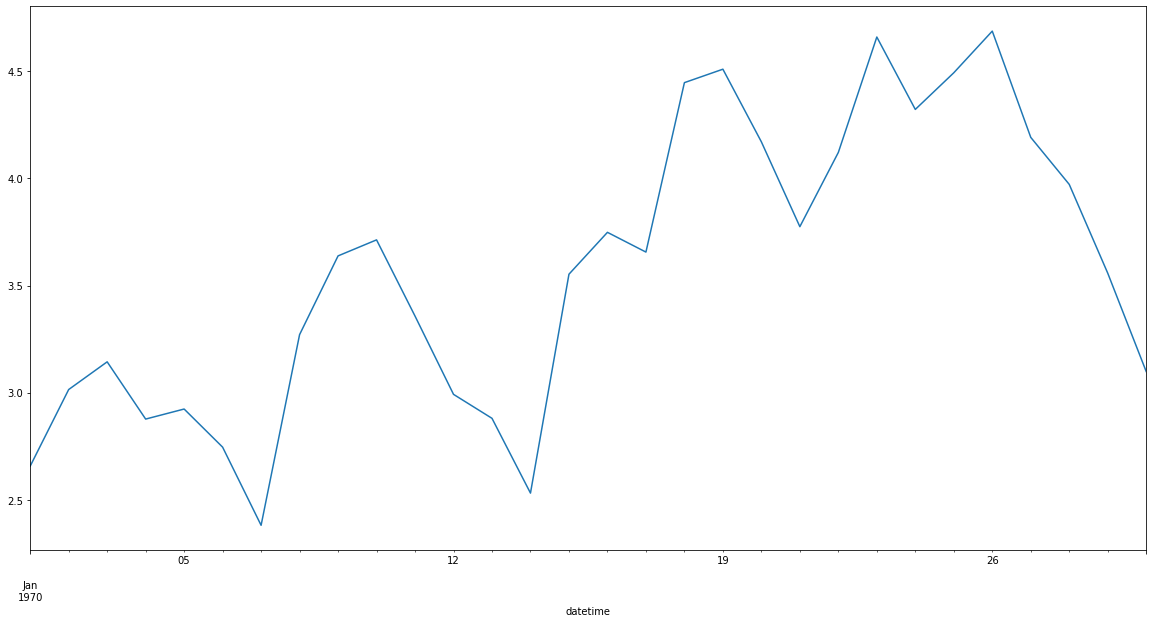

In [109]:
person_transaction.mean().plot()

Do Some machine learning now! we could for example do:

* Predict if someone will view and complete
* predict if someone just complete
* predict if 